In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df['LogPassengers'] = np.log(df['Passengers'])

In [4]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [5]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['LogPassengers'].to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (134, 10) Y.shape (134,)


In [6]:
X

array([[4.71849887, 4.77068462, 4.88280192, ..., 4.99721227, 4.91265489,
        4.77912349],
       [4.77068462, 4.88280192, 4.8598124 , ..., 4.91265489, 4.77912349,
        4.6443909 ],
       [4.88280192, 4.8598124 , 4.79579055, ..., 4.77912349, 4.6443909 ,
        4.77068462],
       ...,
       [6.00388707, 6.03308622, 5.96870756, ..., 6.43294009, 6.40687999,
        6.23048145],
       [6.03308622, 5.96870756, 6.03787092, ..., 6.40687999, 6.23048145,
        6.13339804],
       [5.96870756, 6.03787092, 6.13339804, ..., 6.23048145, 6.13339804,
        5.96614674]])

In [6]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [7]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.9599443783339898

In [8]:
lr.score(Xtest, Ytest)

0.6910953044565618

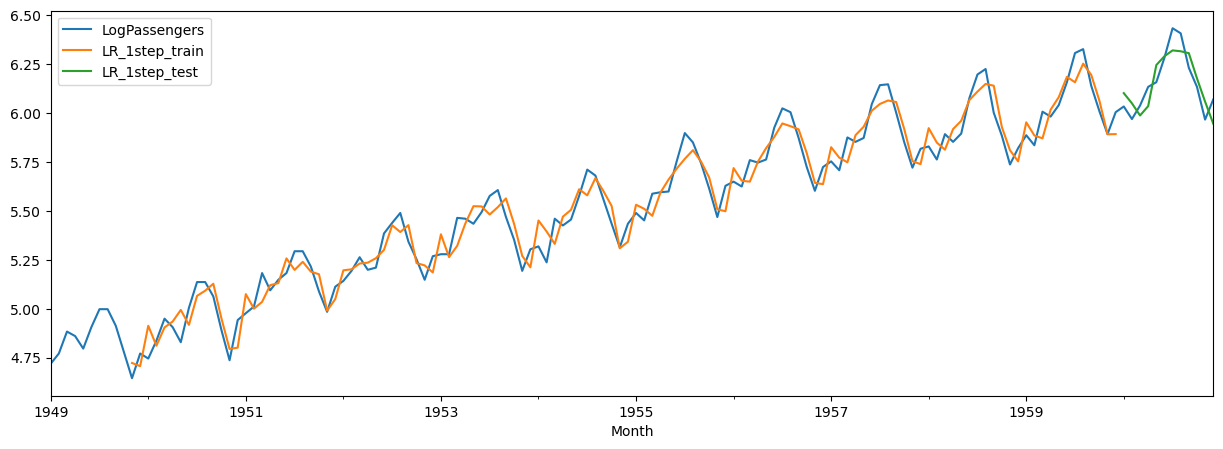

In [9]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)
# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

iteration
0
last_x
[6.00635316 5.98141421 6.04025471 6.15697899 6.30627529 6.32614947
 6.13772705 6.00881319 5.89164421 6.00388707]
p
6.1011980062274755
rolled last_x
[5.98141421 6.04025471 6.15697899 6.30627529 6.32614947 6.13772705
 6.00881319 5.89164421 6.00388707 6.00635316]
last time updated
[5.98141421 6.04025471 6.15697899 6.30627529 6.32614947 6.13772705
 6.00881319 5.89164421 6.00388707 6.10119801]
iteration
1
last_x
[5.98141421 6.04025471 6.15697899 6.30627529 6.32614947 6.13772705
 6.00881319 5.89164421 6.00388707 6.10119801]
p
6.112320666149664
rolled last_x
[6.04025471 6.15697899 6.30627529 6.32614947 6.13772705 6.00881319
 5.89164421 6.00388707 6.10119801 5.98141421]
last time updated
[6.04025471 6.15697899 6.30627529 6.32614947 6.13772705 6.00881319
 5.89164421 6.00388707 6.10119801 6.11232067]
iteration
2
last_x
[6.04025471 6.15697899 6.30627529 6.32614947 6.13772705 6.00881319
 5.89164421 6.00388707 6.10119801 6.11232067]
p
6.108175612308673
rolled last_x
[6.15697899 6

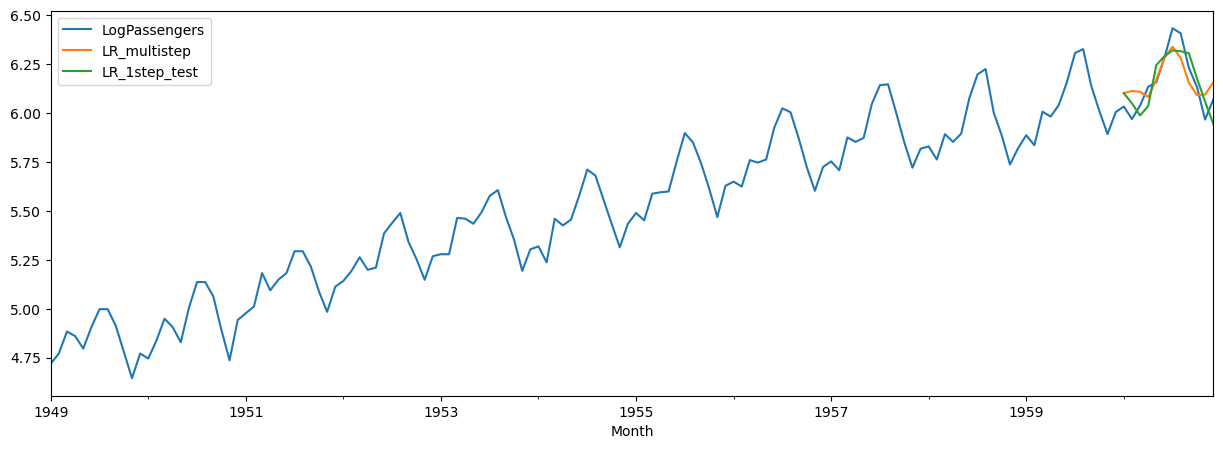

In [11]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]
iteration = 0 
#### incremental multi steps forecasting
while len(multistep_predictions) < Ntest:
    print('iteration')
    print(iteration)
    print('last_x')
    print(last_x)
    p = lr.predict(last_x.reshape(1, -1))[0]
    print('p')
    print(p)
    # update the predictions list
    multistep_predictions.append(p)
      
    # make the new input
    last_x = np.roll(last_x, -1)
    print('rolled last_x')
    print(last_x)
    last_x[-1] = p
    print('last time updated')
    print(last_x)
    iteration = iteration + 1
    

    # save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions
# plot 1-step and multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));


In [14]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

X.shape (123, 10) Y.shape (123, 12)


0.9734607773512528

In [15]:
# SST is zero!
lr.score(Xtest_m, Ytest_m)

/Users/stefanduprey/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [16]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.8018749676715206

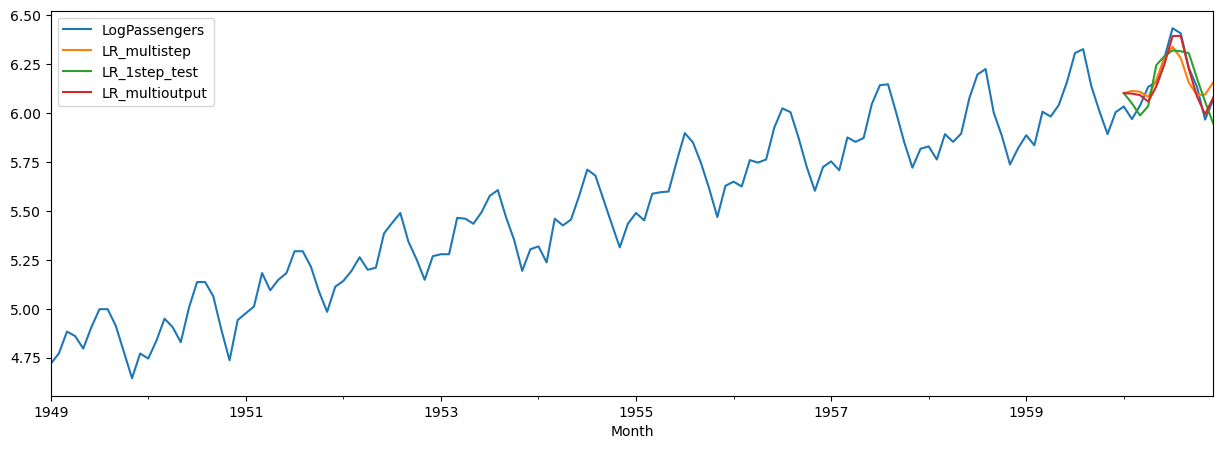

In [17]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()
# plot all forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [18]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.01222932502347524
multi-output MAPE: 0.007178924475039813


In [19]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.017529446164229804


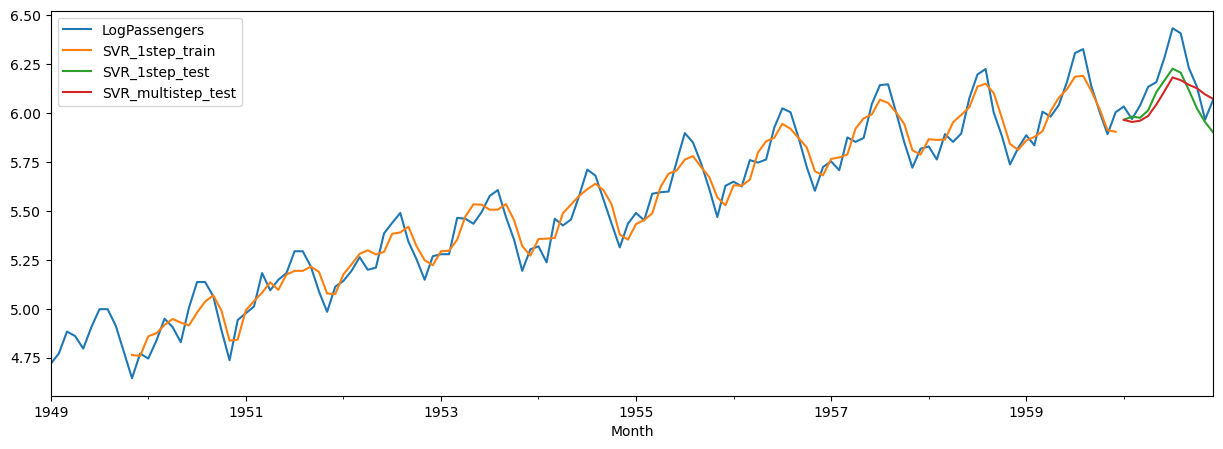

In [20]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.027842130645618027


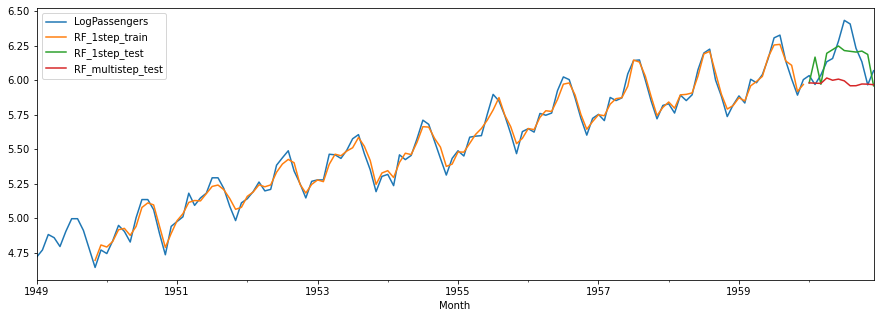

In [18]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [19]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)
  
  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [22]:
multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!


ValueError: y should be a 1d array, got an array of shape (122, 12) instead.

Test MAPE (multi-output): 0.0165858550247038


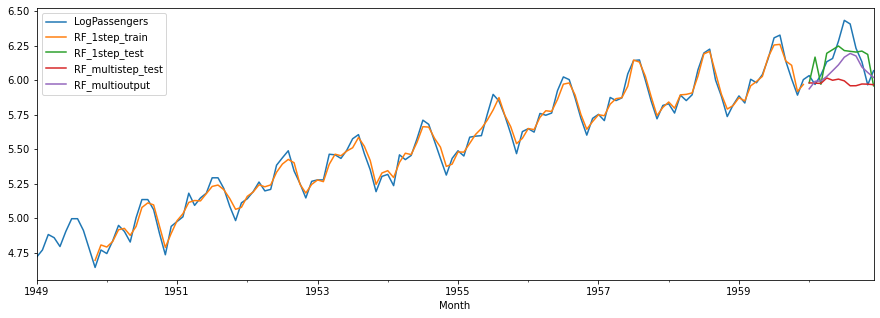

In [21]:
multi_output_forecast(RandomForestRegressor(), "RF")